# 02_plot_headmotion_figure

In [1]:
import numpy as np
from os.path import join as pjoin
from os.path import isdir
import os
import matplotlib.pyplot as plt
from matplotlib import cm, colors
import mne
from mne_bids import write_raw_bids, BIDSPath
from scipy import stats
import re
from scipy import signal
import pandas as pd
from scipy import signal, fftpack
from PIL import Image

In [73]:
# define variables
sub_list = ['{0:0>2d}'.format(sub) for sub in np.arange(1,12)]
run_list = ['{0:0>2d}'.format(run) for run in np.arange(1,9)]

# set path
bids_root = '/nfs/e5/studyforrest/forrest_movie_meg/gump_meg_bids'
results_pth = '/nfs/e5/studyforrest/forrest_movie_meg/tech_val_results'
fig_pth = '/nfs/e5/studyforrest/forrest_movie_meg/tech_val_results/head_motion_figure'
if os.path.exists(fig_pth) is False:
    os.mkdir(fig_pth)


In [74]:
# load data
head_motion = pd.read_pickle(pjoin(results_pth, 'head_motion.pickle'))
head_motion_bins = np.load(pjoin(results_pth, 'head_motion_bins.npy'))
run_deviation = pd.read_pickle(pjoin(results_pth, 'run_deviation.pickle'))

Text(0, 0.5, 'Normalized histgram (%)')

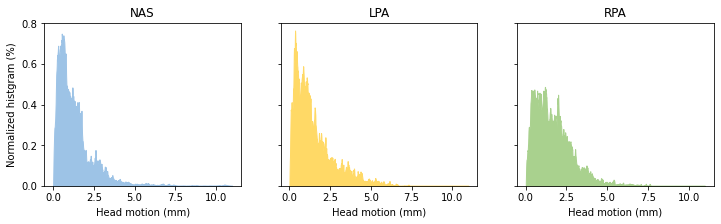

In [75]:
# plot head movement for all data
all_head_motion = np.zeros(head_motion['01']['01'][0].shape)
for sub in sub_list:
    if sub == '01':
        run_ls = run_list + ['09']
    else:
        run_ls = run_list 
    for run in run_ls:
        all_head_motion += head_motion[sub][run][0]

# plot_sub_hmv_hist((all_head_motion.astype(int), np.ones(3)*np.max(head_motion_bins)), head_motion_bins, ['all', 'all'], save_pth=fig_pth, cumulative=True, show=True)

# plot
coord = ['NAS', 'LPA', 'RPA']
color = np.asarray([(157, 195, 230), (255, 217, 102), (169, 209, 142)]) / 255

fig, axes = plt.subplots(1,3,figsize=(12, 3), sharex=True, sharey=True)
[axes.flatten()[i].stackplot((head_motion_bins[0:-1] + head_motion_bins[1:])/2, all_head_motion[i]/all_head_motion[i].sum()*100, color=color[i]) for i in range(3)]

[axes.flatten()[i].set_title(coord[i]) for i in range(3)]
[axes.flatten()[i].set_xlabel('Head motion (mm)') for i in range(3)]
axes.flatten()[0].set_ylabel('Normalized histgram (%)')

In [77]:
cdf = np.cumsum(all_head_motion, axis=1)
for i in np.arange(3):
    cdf[i, :] = cdf[i, :]/cdf[i, -1]

for i in np.arange(3):
    print(f'{coord[i]} 50% is {np.interp(0.5, cdf[i,:], head_motion_bins[1:])} mm')
    print(f'{coord[i]} 95% is {np.interp(0.95, cdf[i,:], head_motion_bins[1:])} mm')

NAS 50% is 0.9896661830582953 mm
NAS 95% is 3.430724132092289 mm
LPA 50% is 1.1027516423544181 mm
LPA 95% is 4.109683728443889 mm
RPA 50% is 1.4560983667780416 mm
RPA 95% is 3.8667750085532027 mm


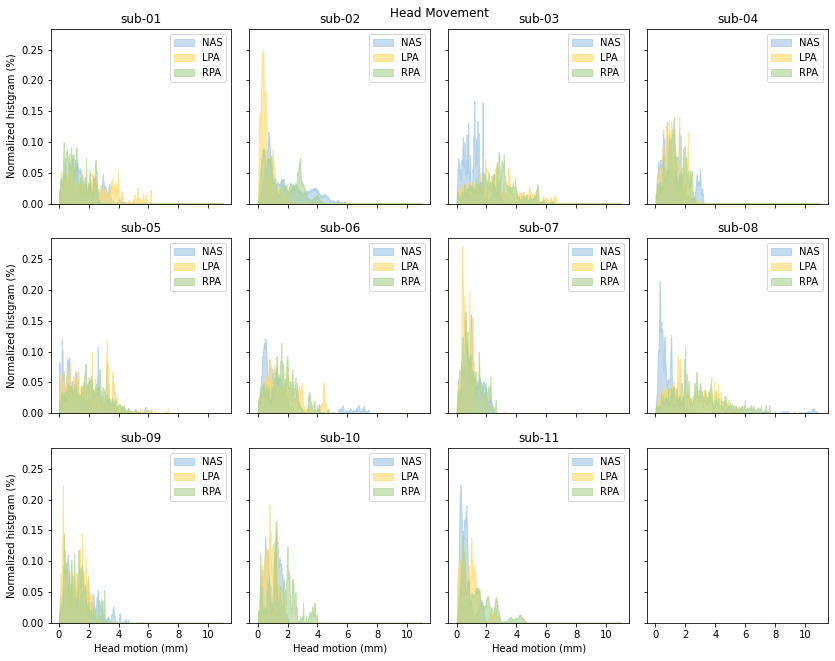

In [78]:
# Supplymentary figure 1
fig, axes = plt.subplots(3, 4, figsize=(12,10), sharex=True, sharey=True)
fig.suptitle('Head Movement')
plt.subplots_adjust(top=0.95, left=0.05, right=0.95, wspace=0.1)

for i, sub in enumerate(sub_list):
    sub_head_motion = np.zeros(head_motion['01']['01'][0].shape)
    
    if sub == '01':
        run_ls = run_list + ['09']
    else:
        run_ls = run_list 
        
    for run in run_ls:
        sub_head_motion += head_motion[sub][run][0]

    ax = axes[i//4][i%4]
    for j in range(3):
        ax.stackplot((head_motion_bins[0:-1] + head_motion_bins[1:])/2, sub_head_motion[j]/np.nansum(sub_head_motion[j])/len(run_ls)*100, color=color[j], alpha=0.6)
    ax.legend(coord, loc=0)
    ax.set_xticks(np.arange(0, 11, 2))
    ax.set_title(f'sub-{sub}')
    if i//4 == 2:
        ax.set_xlabel('Head motion (mm)')
    if i%4 == 0:
        ax.set_ylabel('Normalized histgram (%)')

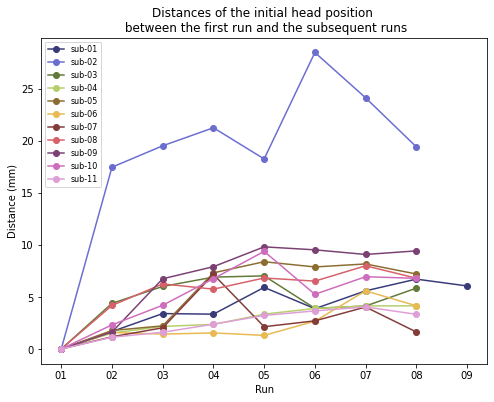

In [79]:
# plot movement during breaks

colors = plt.cm.tab20b(np.linspace(0,1,11))

plt.figure(figsize=(8,6))
for i, sub in enumerate(run_deviation.index):
    all_movement = np.array(list(run_deviation.iloc[i,:]))
    mean_movement = np.mean(all_movement, axis=0)
    # print(mean_movement)
    l = plt.plot(mean_movement, label=f'sub-{sub}', marker='o',color=colors[i])

plt.title('Distances of the initial head position \n between the first run and the subsequent runs')
plt.xlabel('Run')
plt.xticks(ticks=np.arange(9), labels=[f'0{i}' for i in np.arange(1,10)])
plt.ylabel('Distance (mm)')
plt.legend(loc=2, prop={'size':8})